In [1]:
import os

%pwd

'/home/tousside/Documents/recrutement/cowrywise-customer-plan-abandonment/research'

os.chdir("../")

%pwd



'/home/ubuntu/africlimateai/rainfall-prediction'

In [2]:
import pandas as pd

data = pd.read_csv("artifacts/data_transformation/train.csv", index_col="time")
data_test = pd.read_csv("artifacts/data_transformation/test.csv", index_col="time")

data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 2024-11-27 to 2025-06-21
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temperature             207 non-null    float64
 1   feels_like              207 non-null    float64
 2   app_temp                207 non-null    float64
 3   dew_point               207 non-null    float64
 4   humidity                207 non-null    float64
 5   wind_direction          207 non-null    float64
 6   wind_speed              207 non-null    float64
 7   wind_gust               207 non-null    float64
 8   pressure_relative       207 non-null    float64
 9   pressure_absolute       207 non-null    float64
 10  rainfall                207 non-null    float64
 11  temperature(t-1)        207 non-null    float64
 12  temperature(t-2)        207 non-null    float64
 13  temperature(t-3)        207 non-null    float64
 14  temperature(t-4)        207 non

In [20]:
data_test.head(1).drop(columns=["rainfall", "is_rain"]).values[0]

array([ 16.6875    ,  16.6875    ,  16.675     ,  10.35625   ,
        69.08333333, 198.89583333,   0.51041667,   1.54166667,
        30.18020833,  28.31041667,  14.8875    ,  19.86875   ,
        21.10833333,  17.51458333,  17.48333333,  18.06666667,
        17.83958333,  14.8875    ,  19.86875   ,  21.09583333,
        17.51458333,  17.48333333,  18.0625    ,  17.83958333,
        15.04375   ,  18.68333333,  20.34375   ,  16.93125   ,
        16.50625   ,  17.62916667,  18.16458333,  10.95      ,
         7.45416667,   8.72083333,   8.59791667,   6.60833333,
         8.78125   ,  11.77708333,  77.89583333,  46.02083333,
        48.35416667,  58.64583333,  52.54166667,  58.4375    ,
        69.52083333, 273.35416667, 167.33333333, 236.58333333,
       133.10416667, 181.66666667, 213.0625    ,  92.875     ,
         0.48125   ,   2.03958333,   1.57291667,   0.84166667,
         0.60625   ,   0.56458333,   0.76458333,   1.625     ,
         5.2875    ,   3.70208333,   2.08541667,   1.58

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    scaler_path: Path
    classifier_path: Path
    regressor_path: Path
    classifier_params: dict
    regressor_params: dict
    metric_file_name: str
    classification_target_column: str
    regression_target_column: str
    mlflow_uri: str
    batch_size: int


In [4]:
import os
import pandas as pd
import mlflow
import mlflow.sklearn
import numpy as np
import joblib
from urllib.parse import urlparse



from mlProject.constants import *
from mlProject.utils.common import read_yaml, create_directories, save_json
from mlProject import logger


In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params
        schema =  self.schema

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data_path=config.test_data_path,
            scaler_path = config.scaler_path,
            classifier_path = config.classifier_path,
            regressor_path = config.regressor_path,
            classifier_params = params.classification,
            regressor_params = params.regression,
            metric_file_name = config.metric_file_name,
            classification_target_column = schema.TARGET_COLUMN_CLASSIFICATION,
            regression_target_column = schema.TARGET_COLUMN,
            mlflow_uri=config.mlflow_uri,
            batch_size=config.batch_size
           
        )

        return model_evaluation_config



In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch import optim
from torch.utils.data import DataLoader
from copy import deepcopy as dc
from sklearn.metrics import root_mean_squared_error


In [8]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)
        def     __getitem__(self, i):
            return self.X[i], self.y[i]
        


    def log_into_mlflow(self):
        
        mlflow.set_tracking_uri(self.config.mlflow_uri)
        mlflow.set_experiment("rainfall-prediction")
        with mlflow.start_run():
            test_data = pd.read_csv(self.config.test_data_path, index_col="time")
            
            classification_target_column = list(self.config.classification_target_column.keys())[0]
            regression_target_column = list(self.config.regression_target_column.keys())[0]
            targets_columns = [classification_target_column, regression_target_column]

            # Features
            X_test = test_data.drop(columns=targets_columns).values

            # Targets
            y_test = test_data[regression_target_column].values.reshape(-1, 1)

            # Load classifier + scaler
            scaler = joblib.load(self.config.scaler_path)
            classifier = joblib.load(self.config.classifier_path)

            # Scale features
            X_test_scaled = scaler.transform(X_test)
            classifier_preds = classifier.predict(X_test_scaled)

            # Prepare LSTM input
            X_test_lstm = dc(np.flip(X_test_scaled, axis=1))
            vars_dim = X_test_lstm.shape[1]
            X_test_lstm = X_test_lstm.reshape((-1, vars_dim, 1))

            # Torch tensors
            X_test_tensor = torch.tensor(X_test_lstm).float()
            y_test_tensor = torch.tensor(y_test).float()

            test_dataset = self.TimeSeriesDataset(X_test_tensor, y_test_tensor)
            batch_size = self.config.batch_size
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Device
            device = "cuda" if torch.cuda.is_available() else "cpu"

            # Load regression model
            model = torch.load(self.config.regressor_path, weights_only=False)
            model.to(device)
            model.eval()

            predictions = []
            with torch.no_grad():
                for i, (X_batch, _) in enumerate(test_loader):
                    X_batch = X_batch.to(device)
                    
                    # If classifier said 0 → output 0
                    clf_batch_preds = classifier_preds[i * batch_size : (i + 1) * batch_size]
                    batch_preds = []
                    if len(clf_batch_preds) < len(X_batch):
                        # Handle last smaller batch
                        X_batch = X_batch[:len(clf_batch_preds)]
                    
                    for j, clf_pred in enumerate(clf_batch_preds):
                        if clf_pred == 0:
                            batch_preds.append(0.0)
                        else:
                            reg_out = model(X_batch[j].unsqueeze(0))
                            batch_preds.append(reg_out[0].item())
                    
                    predictions.extend(batch_preds)

            predictions = np.array(predictions).reshape(-1, 1)

            scaler_path = self.config.scaler_path
            regressor_path = self.config.regressor_path
            classifier_path = self.config.classifier_path


            rmse = root_mean_squared_error(y_test, predictions)
            mlflow.log_params(self.config.classifier_params)
            mlflow.log_params(self.config.regressor_params)
            mlflow.log_artifact(scaler_path, artifact_path="scaler")
            mlflow.log_artifact(classifier_path, artifact_path="classifier")
            mlflow.log_artifact(regressor_path, artifact_path="regressor")
            mlflow.log_metric('rmse', rmse)
            

            logger.info(f"Final RMSE: {rmse}")
            score={"rmse":rmse}
            save_json(path=Path(self.config.metric_file_name), data=score)
        return predictions, rmse, y_test
        
        
        
        


In [9]:


try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
    prediction, _ , y_test=  model_evaluation_config.log_into_mlflow()
except Exception as e:
    raise e



[2025-09-30 16:43:20,728: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-09-30 16:43:20,731: INFO: common: yaml file: params.yaml loaded successfully]
[2025-09-30 16:43:20,733: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-09-30 16:43:20,734: INFO: common: created directory at: artifacts]
[2025-09-30 16:43:20,735: INFO: common: created directory at: artifacts/model_evaluation]
[2025-09-30 16:43:21,774: INFO: credentials: Found credentials from IAM Role: EC2-MLflow-S3-Access]
[2025-09-30 16:43:22,170: INFO: 812902469: Final RMSE: 5.856219989632395]
[2025-09-30 16:43:22,171: INFO: common: json file saved at: artifacts/model_evaluation/metrics.json]
🏃 View run colorful-slug-470 at: http://ec2-54-91-2-27.compute-1.amazonaws.com:5000/#/experiments/3/runs/8de0cb304e844db8ae045f16c26c71db
🧪 View experiment at: http://ec2-54-91-2-27.compute-1.amazonaws.com:5000/#/experiments/3


In [10]:
prediction

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [4.05034542],
       [4.01934099],
       [0.        ],
       [0.        ],
       [4.02553129],
       [3.97165084],
       [0.        ],
       [0.        ],
       [4.04082775],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [4.03095007],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [11]:
y_test

array([[ 0. ],
       [ 0.9],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [42.7],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 8.1],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ]])

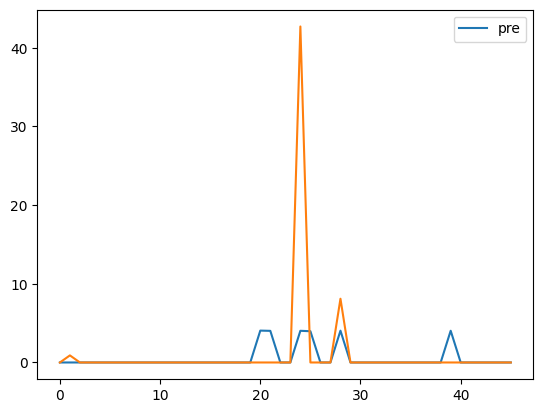

In [14]:
import matplotlib.pyplot as plt
plt.plot(prediction, label="pre")
plt.plot(y_test)
plt.legend()